<a href="https://colab.research.google.com/github/linhnguyen222/DPS-Silo/blob/master/Luna_LSTM_withoutGlove_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###LSTM for full sentence multiclass and binary classification.
For numericalizing sentences, this notebook utilized a dictionary that maps each unique word to a uniqe integer.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from pathlib import Path
from pandas import DataFrame


In [2]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
traindirectory = '/content/drive/My Drive/DSP//BERT-NER/ner_dataset.csv'


Mounted at /content/drive


In [3]:
def read_data(directory):
    ids = []
    texts = []
    labels = []
    for f in directory.glob('*.txt'):
        id = f.name.replace('article', '').replace('.txt','')
        ids.append(id)
        texts.append(f.read_text())
        labels.append(parse_label(f.as_posix().replace('.txt', '.labels.tsv')))
    # labels can be empty 
    return ids, texts, labels

def clean_text(articles, ids):
    texts = []
    for article, id in zip(articles, ids):
        sentences = article.split('\n')
        start = 0
        end = -1
        res = []
        for sentence in sentences:
           start = end + 1
           end = start + len(sentence)  # length of sequence 
           if sentence != "": # if not empty line
               res.append([id, sentence, start, end])
        texts.append(res)
    return texts


def make_dataset(directory):
    ids, texts, labels = read_data(directory)
    texts = clean_text(texts, ids)
    res = []
    for text, label in zip(texts, labels):
        # making positive examples
        tmp = [] 
        pos_ind = [0] * len(text)
        for l in label:
            for i, sen in enumerate(text):
                if l[0] >= sen[2] and l[0] < sen[3] and l[1] > sen[3]:
                    l[4] = 1
                    tmp.append(sen + [l[0], sen[3], l[2], l[3], l[4]])
                    pos_ind[i] = 1
                    l[0] = sen[3] + 1
                elif l[0] != l[1] and l[0] >= sen[2] and l[0] < sen[3] and l[1] <= sen[3]: 
                    tmp.append(sen + l)
                    pos_ind[i] = 1
        # making negative examples
        dummy = [0, 0, 'O', 0, 0]
        for k, sen in enumerate(text):
            if pos_ind[k] != 1:
                tmp.append(sen+dummy)
        res.append(tmp)     
    return res

def parse_label(label_path):
    labels = []
    f= Path(label_path)
    
    if not f.exists():
        return labels

    for line in open(label_path):
        parts = line.strip().split('\t')
        labels.append([int(parts[2]), int(parts[3]), parts[1], 0, 0])
    labels = sorted(labels) 

    if labels:
        length = max([label[1] for label in labels]) 
        visit = np.zeros(length)
        res = []
        for label in labels:
            if sum(visit[label[0]:label[1]]):
                label[3] = 1
            else:
               visit[label[0]:label[1]] = 1
            res.append(label)
        return res 
    else:
        return labels

In [10]:
#train set
dataset=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/train'))

In [11]:

#df = pd.read_csv(Path("/content/export-train-seq"))
#df.head()     


empty=[]
for i in dataset:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty.append(temp)

df=pd.concat(empty) 

df = df.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df.head()
df.prop.value_counts()
possible_labels=df.prop.unique()
df=df.reset_index()
del df['index']



In [12]:
df.head()

,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop
0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism
1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism
2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification
3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation"
4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O


In [24]:
print ("size of train set is: ", df.shape[0])

size of train set is:  20242


In [25]:
dataset_test=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/test'))


In [26]:

#test dataframe
empty=[]
for i in dataset_test:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty.append(temp)

df_test=pd.concat(empty)  
df_test = df_test.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df_test.prop.value_counts()
df_test=df_test.reset_index()

In [16]:
df = pd.concat([df, df_test])


In [21]:
del df['index']
df=df.reset_index()
del df['index']



In [22]:

label_dict={'O': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3, 
 'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7,
 'Exaggeration,Minimisation': 8, 'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12,
 'Thought-terminating_Cliches': 13, 'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16,
 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}


label_dict
df['label']=df.prop.replace(label_dict)
df.head()
df['binary']=10
df.at[1,'binary']=11
df.iloc[11]['label']==0

True

In [23]:

#this works
for i in range (0, df.shape[0]):
    if df.iloc[i]['label']==0  :
        
        df.at[i, 'binary']= 0 
    else:
        #False
        df.at[i, 'binary']= 1 
        
df['sentence_length']=0

for i in range (0, df.shape[0]):
    df.at[i,'sentence_length']=df.iloc[i]['end_sent']-df.iloc[i]['start_sent'] 
        
        
     
df['prop_length']=0
for i in range (0, df.shape[0]):
    df.at[i,'prop_length']=df.iloc[i]['end_prop']-df.iloc[i]['start_prop'] 
        
        

In [27]:
df.head()

,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,label,binary,sentence_length,prop_length
0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism,7,1,178,41
1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism,7,1,72,51
2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification,6,1,142,76
3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation",8,1,109,57
4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O,0,0,59,0


In [28]:
print(df.shape[0])

20242


####Here we handle the problem that some sentences have more than 1 label. We first group by the dataframe on the basis of similar full_length sentences. 

In [29]:
groupedbysent = df.groupby('full_sent')


In [30]:
all_tokenized_labels=[]
new=df['full_sent'].unique()

for i in range (len(groupedbysent)):
    group=groupedbysent.get_group(new[i])
    group_labels=group['label']
    temp=[]
    for j in range (group_labels.size):
        temp.append(group_labels.iloc[j])
    all_tokenized_labels.append(temp)
    
        
      
all_encoded=np.zeros((len(groupedbysent), 19)) 

for i in range (len(groupedbysent)):    
    for  idx, val in enumerate (all_tokenized_labels[i]):
        all_encoded[i][val]=1  

In [31]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
#import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [33]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each  sent.
MAX_SEQUENCE_LENGTH = 135
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
#tokenizer.fit_on_texts(df['full_sent'].values)
df = df.drop_duplicates(subset = ["full_sent"])

tokenizer.fit_on_texts(df['full_sent'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 23000 unique tokens.


In [38]:
X = tokenizer.texts_to_sequences(df['full_sent'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (16285, 135)


In [35]:
print(X[:30,100:130])


[[    0     0     0     0     0  1586  7675     1   125     5    88   126
      3   130    12    11   388    16  1506   102   557   117  3376     3
   4588   277     5    21   126  2303]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0    98  3620    10
     88  5083    91     1   157   444]
 [    0     0     0     0     0     0     0     0     0     0     0  1586
    299   108    14    30   615    82     2     1  4209    74   421   162
     16    15   516  4589    21   153]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     1   112  3377  1461    21   153    30   119    12
     42    32  1141     9    21   416]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
   1296  2989  3621    17    44   176]
 [    0     0     0     0     0     0     0     6   164  2188  29

In [39]:
#Y = pd.get_dummies(df['label']).values

#Y=np.load(Path("/content/new_label.npy"))
Y=all_encoded
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (16285, 19)


In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(14656, 135) (14656, 19)
(1629, 135) (1629, 19)


In [41]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(19, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 135, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 135, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 19)                3819      
Total params: 5,244,619
Trainable params: 5,244,619
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                                                                                                                         patience=3, min_delta=0.0001)])

Epoch 1/10
207/207 [==============================] - 95s 460ms/step - loss: 1.5466 - accuracy: 0.7090 - val_loss: 1.5532 - val_accuracy: 0.7156
Epoch 2/10
207/207 [==============================] - 95s 458ms/step - loss: 1.4203 - accuracy: 0.7135 - val_loss: 1.5406 - val_accuracy: 0.7087
Epoch 3/10
207/207 [==============================] - 95s 458ms/step - loss: 1.2186 - accuracy: 0.7537 - val_loss: 1.5626 - val_accuracy: 0.7067
Epoch 4/10
207/207 [==============================] - 95s 459ms/step - loss: 1.0194 - accuracy: 0.8044 - val_loss: 1.6284 - val_accuracy: 0.6903
Epoch 5/10
207/207 [==============================] - 95s 460ms/step - loss: 0.8862 - accuracy: 0.8298 - val_loss: 1.7644 - val_accuracy: 0.6849


In [44]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

51/51 [==============================] - 2s 35ms/step - loss: 1.8295 - accuracy: 0.6839
Test set
  Loss: 1.829
  Accuracy: 0.684


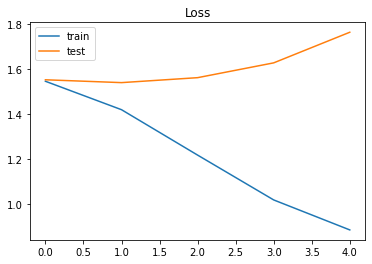

In [45]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

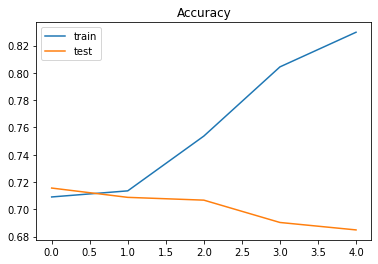

In [46]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [58]:
new_complaint = ['The police and law and government should decide']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
#labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']

labels=['O', 'Black-and-White_Fallacy', 'Loaded_Language', 'Flag-Waving', 
 'Name_Calling,Labeling', 'Slogans', 'Causal_Oversimplification', 'Whataboutism',
 'Exaggeration,Minimisation', 'Doubt', 'Appeal_to_Authority', 'Repetition', 'Appeal_to_fear-prejudice',
 'Thought-terminating_Cliches', 'Bandwagon', 'Red_Herring', 'Reductio_ad_hitlerum',
 'Obfuscation,Intentional_Vagueness,Confusion', 'Straw_Men']



print(pred, labels[np.argmax(pred)])

[[0.13653502 0.00507157 0.05112172 0.00351307 0.02031097 0.00482181
  0.00668627 0.00190907 0.01044572 0.00969169 0.00271101 0.01060509
  0.00964457 0.00272946 0.00079464 0.00111665 0.00226751 0.00037204
  0.00085822]] O


In [59]:
pred = model.predict(X_test)
print("size of predicted array is: ", len(pred))
print("size of Y_test array is: ", len(Y_test))

size of predicted array is:  1629
size of Y_test array is:  1629


In [60]:
print(Y_test[0])


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [61]:
print(pred[400])


[0.13942143 0.00332735 0.01955515 0.00729201 0.00302475 0.00314102
 0.00600651 0.00178728 0.00411921 0.01218196 0.00107581 0.00419551
 0.00375864 0.0021581  0.00045046 0.00074865 0.00194696 0.00033471
 0.00060879]


In [62]:
np.argmax(pred[400])

0

We find the index of the highest value (predicted class). 



In [63]:
pred1=[]
for i in range (len(pred)):
  pred1.append(np.argmax(pred[i]))

In [64]:
Y_test1=[]
for i in range (len(pred)):
  Y_test1.append(np.argmax(Y_test[i]))


In [65]:
from sklearn.metrics import precision_recall_fscore_support as score

#predicted = [1,2,3,4,5,1,2,1,1,4,5] 
#y_test = [1,2,3,4,5,1,2,1,1,4,1]

precision, recall, fscore, support = score(Y_test1, pred1 )

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))



precision: [0.76031294 0.         0.30952381 0.25       0.06896552 0.
 0.         0.         0.         0.         0.         0.
 0.5        0.         0.         0.         0.         0.
 0.        ]
recall: [0.91917455 0.         0.1875     0.0625     0.07272727 0.
 0.         0.         0.         0.         0.         0.
 0.03846154 0.         0.         0.         0.         0.
 0.        ]
fscore: [0.83223044 0.         0.23353293 0.1        0.07079646 0.
 0.         0.         0.         0.         0.         0.
 0.07142857 0.         0.         0.         0.         0.
 0.        ]
support: [1163    7  208   16   55    9   15    8   24   36    8   38   26    5
    2    2    5    1    1]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [66]:
df1 = pd.DataFrame({ 'precision': precision, 'recall':recall, 'Fscore':fscore, 'support':support })


In [67]:
from tabulate import tabulate
print(tabulate(df1, headers='keys', tablefmt='psql'))


+----+-------------+-----------+-----------+-----------+
|    |   precision |    recall |    Fscore |   support |
|----+-------------+-----------+-----------+-----------|
|  0 |   0.760313  | 0.919175  | 0.83223   |      1163 |
|  1 |   0         | 0         | 0         |         7 |
|  2 |   0.309524  | 0.1875    | 0.233533  |       208 |
|  3 |   0.25      | 0.0625    | 0.1       |        16 |
|  4 |   0.0689655 | 0.0727273 | 0.0707965 |        55 |
|  5 |   0         | 0         | 0         |         9 |
|  6 |   0         | 0         | 0         |        15 |
|  7 |   0         | 0         | 0         |         8 |
|  8 |   0         | 0         | 0         |        24 |
|  9 |   0         | 0         | 0         |        36 |
| 10 |   0         | 0         | 0         |         8 |
| 11 |   0         | 0         | 0         |        38 |
| 12 |   0.5       | 0.0384615 | 0.0714286 |        26 |
| 13 |   0         | 0         | 0         |         5 |
| 14 |   0         | 0         

In [68]:
from sklearn.metrics import f1_score

In [69]:
f1_score(Y_test1, pred1, average='weighted')

0.6284897483261538